# Simple Graph Neural Networks for Velocity Sim2Real Transfer
---
> Graph neural network model for vertex dynamics and tension prediction

- All simulated movies, regardless of their simulation param-s, use the same *normalisation constants*.
- Hara movies (node velocity data) and ablation (recoil data) movies have different spatio-temporal resolutions:
    - After scaling them to the same length scale and frame rate (microns/10s), we use the average edge length to normalise spatial variables (displacement and position; frame rate is assumed to be 10s for all movies including the simulated movies)

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`, `ScalePressure(0.33,shift=0.1)]`|
|Hara movies    | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`,`ScaleVelocity(0.5*26.32)]`|
|Hara ablation | short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels | (not used for testing velocity) |


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

### Datasets

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [5]:
!rm -dr simgnn_data/single_distr_sims/train/processed
# !rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed
!rm -dr simgnn_data/hara_movies/processed

rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/val/processed': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies/processed': No such file or directory


In [59]:
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed/
!rm -dr simgnn_data/hara_movies/processed/

rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/': No such file or directory
rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/val/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies/processed/': No such file or directory


In [112]:
window_size = 5

# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(1.0*0.5),
                   ScaleTension(0.634, shift=0.6), ScalePressure(0.33, shift=0.1 ), Reshape_x((-1,window_size*2)) ] )

Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))]) # Hara movie dataset norm

# Hara movie datasets
seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorm)
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorm)
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorm)
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorm)

datasets_dict = {'train': seg001[:20],#sim1,
                 'val': sim1_val,
                 'val2' : sim2_val,
                 'early' : seg001[-5:],
                 'mid'   : seg003[-5:],
                 'late'  : seg005[-5:],
                'raw': seg001_raw[len(seg001_raw)//3-1-5:len(seg001_raw)//3-1]}
dataset_legend={'train': 'Train (Hara:early)',
                'val': 'Sim(Non-zero)',
                'val2': 'Sim(Zero)',
               'early': 'Hara (early)',
                'mid': 'Hara(mid)',
                'late': 'Hara(late)',
               'raw': 'Hara(early:raw)'}

# datasets_dict = {'train': sim1,
#                  'val': sim2,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:]}
# dataset_legend={'train': 'Train (sim1)',
#                 'val': 'Val(sim2)',
#                 'early': 'Hara (early)',
#                 'mid': 'Hara(mid)',
#                 'late': 'Hara(late)'}

train : HaraMovies(20)
size:20

Frame 1:
CellData(cell2node_index=[2, 492], edge_attr=[225, 2], edge_index=[2, 225], node2cell_index=[2, 492], pos=[164, 2], x=[164, 10], y=[164, 2])


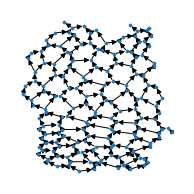

In [113]:
k='train'
print('{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Helper functions

In [114]:
def plot_losses(train_log, loaders, dataset_legend,figsize=[15,8]):
    if figsize is not None:
        plt.figure(figsize=figsize)
    training_epochs = np.arange(train_log['total_epochs'])
    for data_name in loaders:
        plt.plot(training_epochs, train_log[f'{data_name}_loss_tot'],lw=3,label=f'{dataset_legend[data_name]}')
    plt.legend();


def plot_velocity_predictions(vel_pred, vel_tgt, dataset_legend, figsize=[15,7]):
    var_type = 0
    var_name = '$\Delta{}x$'

    for data_name in vel_pred:
        minY, maxY  = torch.cat(vel_tgt[data_name],dim=0).min(), torch.cat(vel_tgt[data_name],dim=0).max()

        fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)    
        for k,ax in enumerate(axs):
            ax.plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
            ax.plot(torch.cat(vel_tgt[data_name], dim=0)[:,k],
                    torch.cat(vel_pred[data_name], dim=0)[:,k], 'o',ms=10,mfc='tomato',alpha=.25)
            ax.set_xlabel('True');
            ax.set_ylabel('Predicted')
            ax.set_title(f'{var_name}$_{k}$');
        plt.suptitle(f'{dataset_legend[data_name]}')
        plt.show()

#### Persistence Loss

In [115]:
print('Persistence:')
for k in datasets_dict:
    print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

Persistence:
	- Train (Hara:early): {'mae': 0.026774133, 'mse': 0.0012163394}
	- Sim(Non-zero): {'mae': 0.06426177, 'mse': 0.007703601}
	- Sim(Zero): {'mae': 0.063635536, 'mse': 0.008163488}
	- Hara (early): {'mae': 0.028903184, 'mse': 0.0013524193}
	- Hara(mid): {'mae': 0.021136116, 'mse': 0.00074782554}
	- Hara(late): {'mae': 0.018739773, 'mse': 0.0005740396}
	- Hara(early:raw): {'mae': 0.04471593, 'mse': 0.00466818}


In [21]:
len(datasets_dict['train'])

280

### Experiments

#### Plain MLP
> y=MLP(x) models (no graph), uses single node trends to predict trajectory

- Train on 5 movies from same sim param distrib.
    - Best MLP model for `window_size=5`: `net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[16,8,8,8,4],dropout_p=dropout_p)`
- Using 5+5 movies from two different sim param distrib-s
    - Needs more complex model.

In [116]:
from simgnn.nn import Plain_MLP, PlainSquaredMLP

In [120]:
torch.manual_seed(0)

dropout_p = 0.1
num_epochs = 30
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')

# net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[512,256,128,64,32,16],dropout_p=dropout_p).to(device)
net = PlainSquaredMLP(in_features=window_size*2, out_features=2, hidden_dims=[512,512,256,128,64,32,32,16],dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
# loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs,follow_batch=['cell_pressures','edge_index'], shuffle=True),
#            'val': DataLoader(datasets_dict['hara'], batch_size=bs),
#            'sim': DataLoader(datasets_dict['sim'], batch_size=bs,follow_batch=['cell_pressures','edge_index'])}
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val':    DataLoader(datasets_dict['val'], batch_size=bs),
           'val2':    DataLoader(datasets_dict['val2'], batch_size=bs),
           'early':    DataLoader(datasets_dict['early'], batch_size=bs),
           'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
           'late': DataLoader(datasets_dict['late'], batch_size=bs)}
# loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
#            'val':    DataLoader(datasets_dict['val'], batch_size=bs),
#            'early':    DataLoader(datasets_dict['early'], batch_size=bs),
#            'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
#            'late': DataLoader(datasets_dict['late'], batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [121]:
print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss,
                               return_best=return_best)

05062021_220834_PlainSquaredMLP_dp0.1bs2w5
---
Training param-s: #epochs=30, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot= 0.01544; train_loss_y= 0.01544; |val_loss_tot= 0.01135; |val2_loss_tot= 0.01182; |early_loss_tot=0.005882; |mid_loss_tot=0.004518; |late_loss_tot=0.003284; |1s
Epoch 1/29: train_loss_tot=0.004721; train_loss_y=0.004721; |val_loss_tot=0.009368; |val2_loss_tot= 0.00983; |early_loss_tot=0.003735; |mid_loss_tot=0.002808; |late_loss_tot=0.001783; |2s
Epoch 2/29: train_loss_tot=0.003296; train_loss_y=0.003296; |val_loss_tot=0.007371; |val2_loss_tot=0.007838; |early_loss_tot=0.001429; |mid_loss_tot=0.0007837; |late_loss_tot=0.0004831; |3s
Epoch 3/29: train_loss_tot=0.002622; train_loss_y=0.002622; |val_loss_tot=0.007425; |val2_loss_tot=0.007894; |early_loss_tot=0.001589; |mid_loss_tot=0.0008246; |late_loss_tot=0.0005713; |5s
Epoch 4/29: train_loss_tot=0.002261; train_loss_y=0.002261; |val_loss_tot=0.007275; |val2

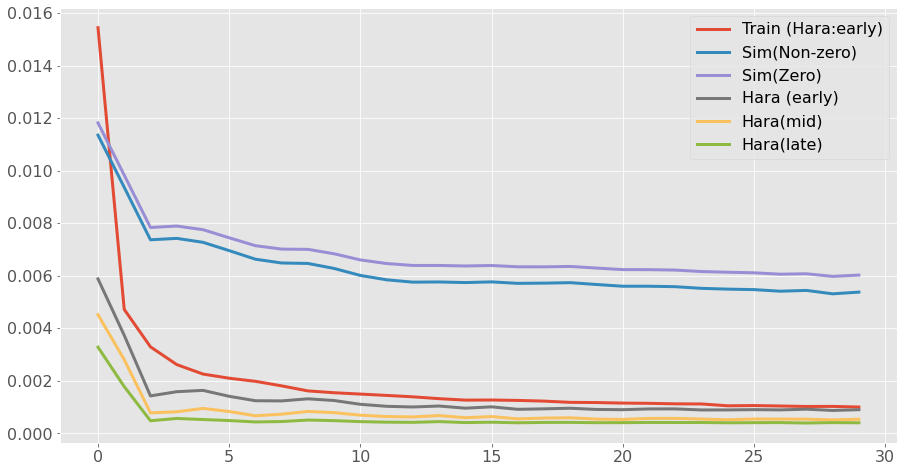

- train_loss_tot =0.0007448217365890741;
- train_loss_y =0.0007448217365890741;
- train_loss_T =None;
- train_loss_P =None;
- val_loss_tot =0.0053792655637193605;
- val_loss_y =0.0053792655637193605;
- val_loss_T =None;
- val_loss_P =None;
- val2_loss_tot =0.006027934165369949;
- val2_loss_y =0.006027934165369949;
- val2_loss_T =None;
- val2_loss_P =None;
- early_loss_tot =0.0009035881841555238;
- early_loss_y =0.0009035881841555238;
- early_loss_T =None;
- early_loss_P =None;
- mid_loss_tot =0.0005421762587502598;
- mid_loss_y =0.0005421762587502598;
- mid_loss_T =None;
- mid_loss_P =None;
- late_loss_tot =0.00040529799298383296;
- late_loss_y =0.00040529799298383296;
- late_loss_T =None;
- late_loss_P =None;



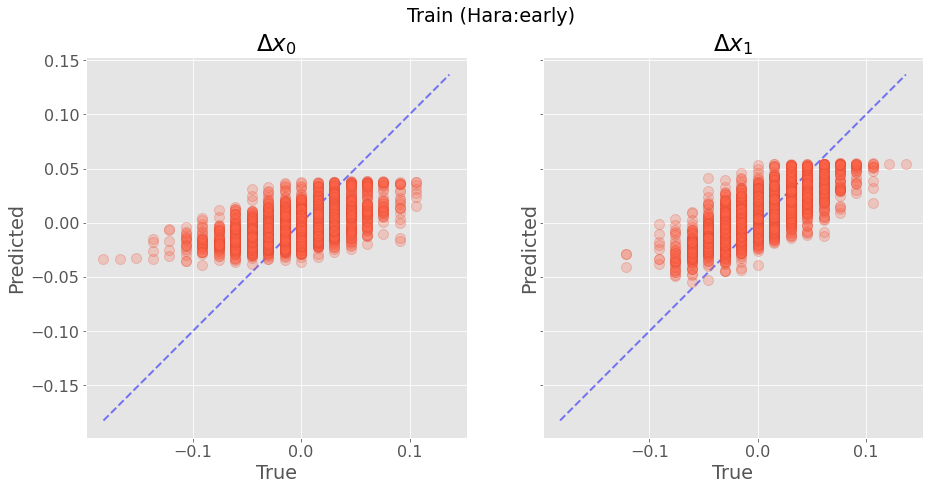

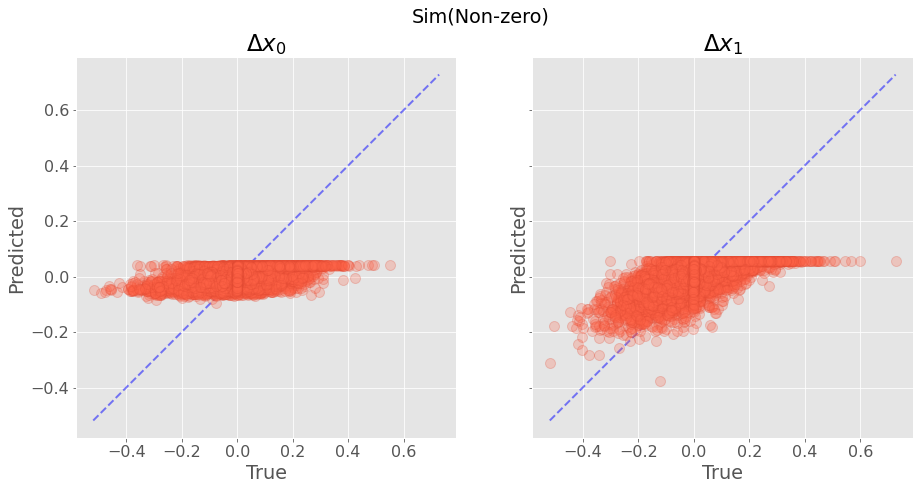

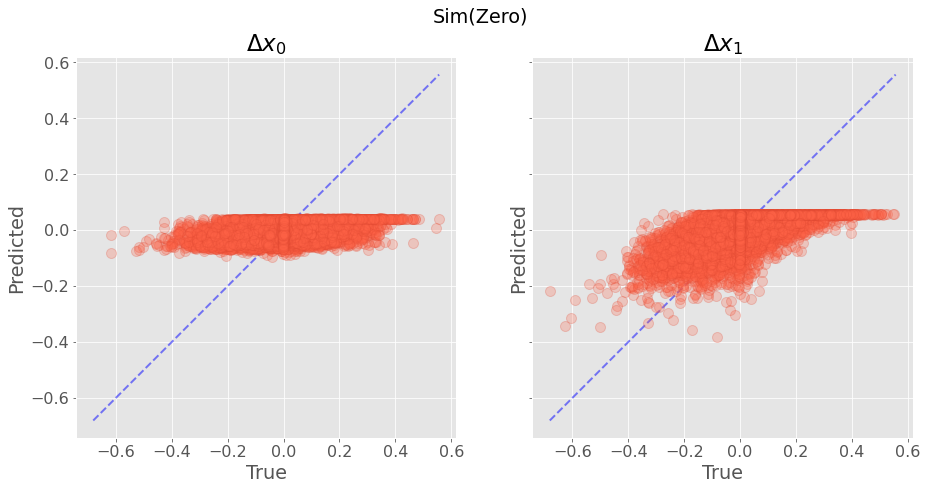

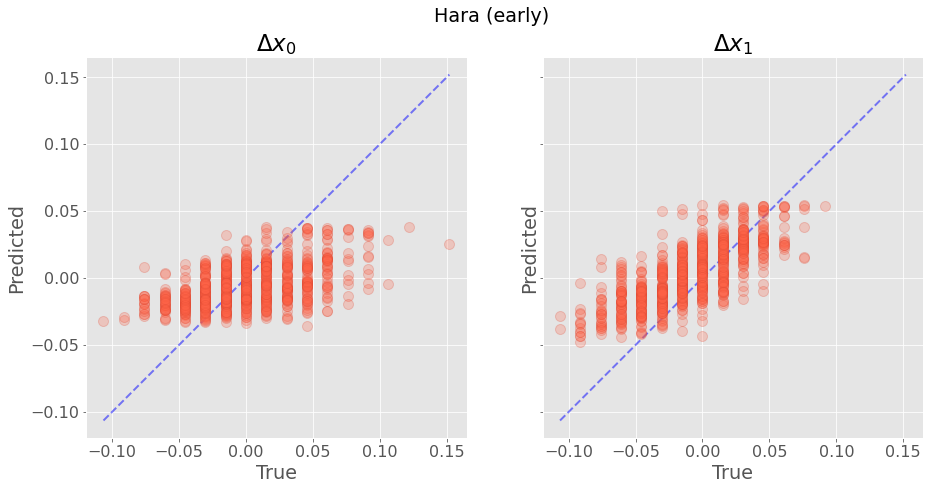

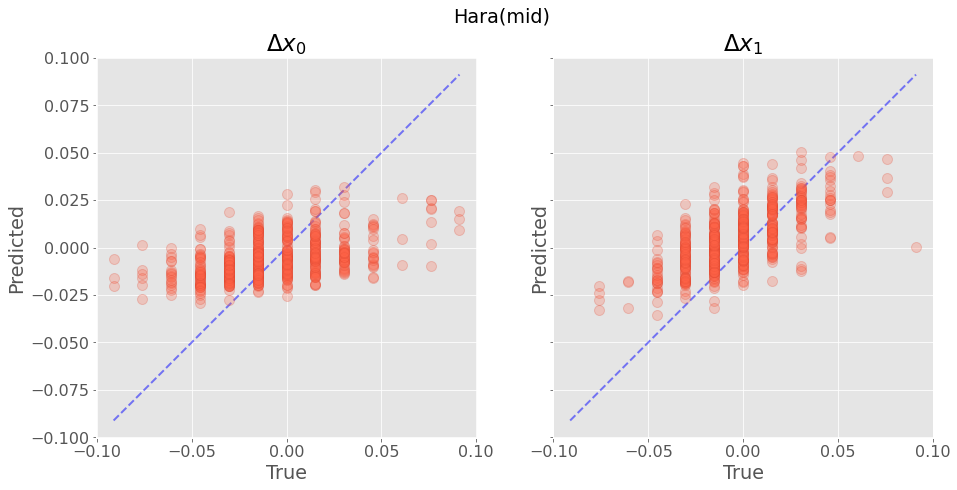

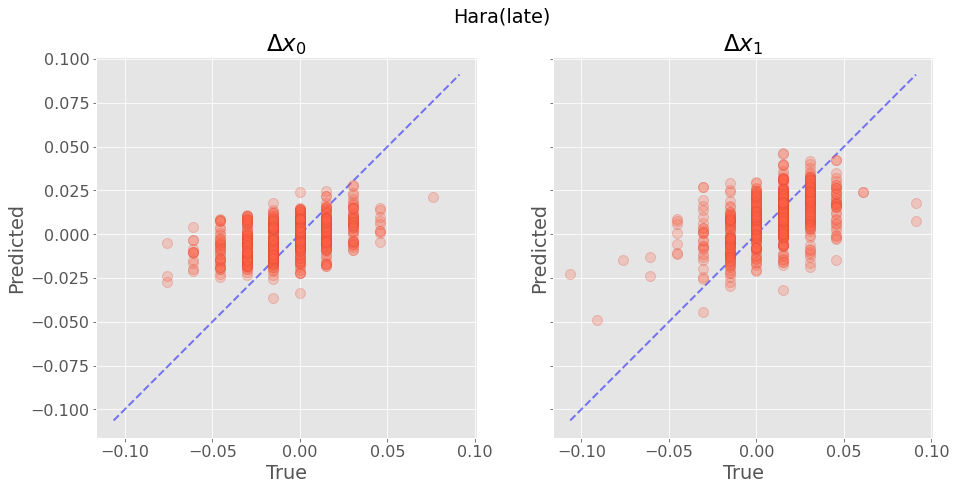

In [122]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [30]:
write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

Model weights saved in 
./simgnn_data/saved_models/05062021_190513_PlainSquaredMLP_dp0bs2w5_net.pkl


---

#### Load Model and Check Performance

In [ ]:
dropout_p = 0.42
# net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[32,16,16,16,8,8],dropout_p=dropout_p).to(device)
# net_weights_dict = torch.load(path.join(save_dir, '31052021_064810_Plain_MLP_dp0.1bs32w5best_net.pkl'), map_location=device)

net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[64,32,16,16,16,16],dropout_p=dropout_p).to(device)
net_weights_dict = torch.load(path.join(save_dir, '29052021_190220_Plain_MLP_dp0.5bs32w5_net.pkl'), map_location=device)

net.load_state_dict(net_weights_dict)
net.eval();

In [ ]:
# predict(net, train1[0], loss_func=loss_func, use_force_loss = use_force_loss['train'], return_losses = False, device=device)

In [ ]:
from simgnn.train import predict, predict_batch
# plot losses
# plot_losses(train_log, loaders, dataset_legend); plt.show()
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))
plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [ ]:
# plt.figure(figsize=[35,10])
# ax1 = plt.subplot(1,4,1)
# ax1.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# ax1.hlines(0.0041163876,0,30)
# ax1.axis([0,30,0.00325,.0043]);
# ax1.legend();

# ax2 = plt.subplot(1,4,2,sharex=ax1,sharey=ax1)
# ax2.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=4,label='Early',alpha=.7)
# ax2.hlines(0.0042118663,0,30)
# ax2.legend();

# ax3 = plt.subplot(1,4,3,sharex=ax1,sharey=ax1)
# ax3.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=4,label='Middle',alpha=.7)
# ax3.hlines(0.00330922,0,30)
# ax3.legend();


# ax4 = plt.subplot(1,4,4,sharex=ax1)
# ax4.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=4,label='Late',alpha=.7)
# ax4.hlines(0.004734805,0,30)
# ax4.axis([0,30,0.004,.0048]);
# ax4.legend();

In [ ]:
# plt.figure(figsize=[15,8])
# plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
# plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# plt.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=3,label='Early',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=3,label='Middle',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=3,label='Late',alpha=.7)
# plt.legend();
# plt.axis([0,30,0,.009]);


---

#### Single Message Passing Step
> Single MP step, uses graph and relative node positions w.r.t. connected neighbouring nodes

- Single MP step w/ a very simple Update mlp. Update stage is equivalent to the node model (plain mlp) w/ an additional edge features as messages.

In [31]:
from simgnn.nn import Single_MP_step, SingleMPStepSquared
#mlp, Message, AggregateUpdate, Aggregate

In [123]:
torch.manual_seed(0)

dropout_p = 0.2
weight_decay = 0
num_epochs = 200
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')
# Deep model msg_dim=320; msg_nlayers=4; upd_dim=514; upd_nlayers=3
msg_dim = 32
msg_nlayers = 4 # in+out+#hidden_layers
upd_dim = 128
upd_nlayers = 5# in(msg,x)+out(y)+#hidden_layers

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                     message_out_features=msg_dim, message_hidden_dims=[msg_dim for k in range(msg_nlayers-2)],
                     aggr='mean', update_hidden_dims=[upd_dim for k in range(upd_nlayers-2)], dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
# opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# opt = torch.optim.Adamax(net.parameters(), lr=lr)
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(opt, 100, gamma=0.1)

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val':    DataLoader(datasets_dict['val'], batch_size=bs),
           'val2':    DataLoader(datasets_dict['val2'], batch_size=bs),
           'early':    DataLoader(datasets_dict['early'], batch_size=bs),
           'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
           'late': DataLoader(datasets_dict['late'], batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [124]:
print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

05062021_220941_Single_MP_step_dp0.2bs2w5
---
Training param-s: #epochs=200, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/199: train_loss_tot=0.002739; train_loss_y=0.002739; |val_loss_tot=0.007658; |val2_loss_tot= 0.00812; |early_loss_tot=0.001405; |mid_loss_tot=0.0009154; |late_loss_tot=0.0007162; |1s
Epoch 1/199: train_loss_tot=0.001461; train_loss_y=0.001461; |val_loss_tot=0.007828; |val2_loss_tot=0.008292; |early_loss_tot=0.001671; |mid_loss_tot=0.0008619; |late_loss_tot=0.0007378; |2s
Epoch 2/199: train_loss_tot=0.001317; train_loss_y=0.001317; |val_loss_tot=0.007306; |val2_loss_tot=0.007779; |early_loss_tot=  0.0013; |mid_loss_tot=0.0007231; |late_loss_tot=0.0005225; |3s
Epoch 3/199: train_loss_tot=0.001257; train_loss_y=0.001257; |val_loss_tot=0.007162; |val2_loss_tot=0.007643; |early_loss_tot=0.001272; |mid_loss_tot=0.0006506; |late_loss_tot=0.0005296; |5s
Epoch 4/199: train_loss_tot=0.001176; train_loss_y=0.001176; |val_loss_tot=0.0068

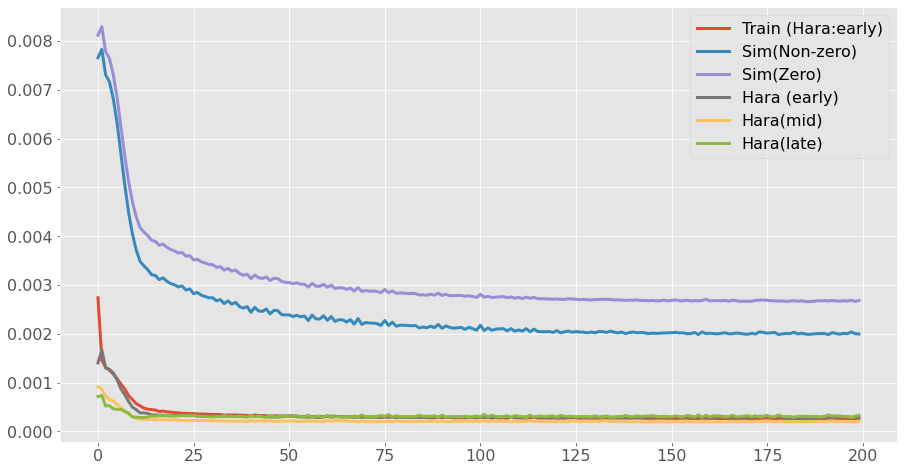

- train_loss_tot =0.00022122316440800204;
- train_loss_y =0.00022122316440800204;
- train_loss_T =None;
- train_loss_P =None;
- val_loss_tot =0.00199758203471016;
- val_loss_y =0.00199758203471016;
- val_loss_T =None;
- val_loss_P =None;
- val2_loss_tot =0.0026832899186580695;
- val2_loss_y =0.0026832899186580695;
- val2_loss_T =None;
- val2_loss_P =None;
- early_loss_tot =0.0002886436646804214;
- early_loss_y =0.0002886436646804214;
- early_loss_T =None;
- early_loss_P =None;
- mid_loss_tot =0.00021078576100990175;
- mid_loss_y =0.00021078576100990175;
- mid_loss_T =None;
- mid_loss_P =None;
- late_loss_tot =0.0003314287052489817;
- late_loss_y =0.0003314287052489817;
- late_loss_T =None;
- late_loss_P =None;



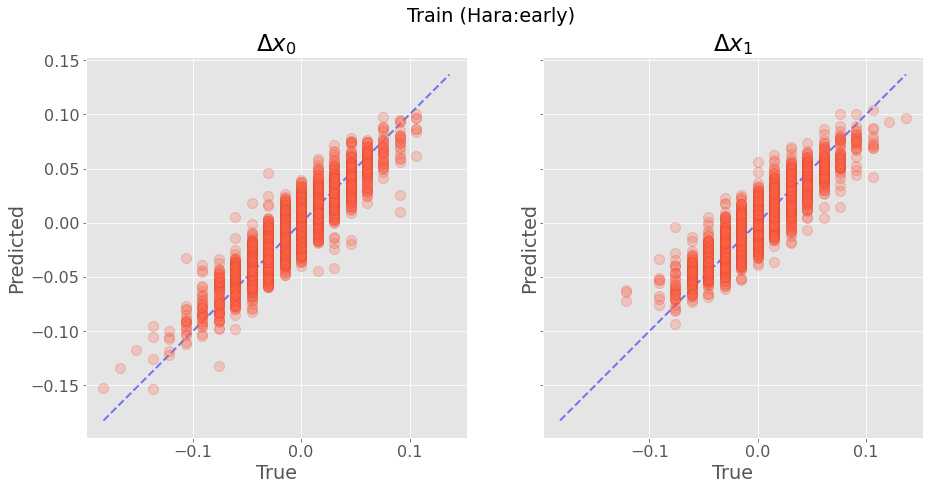

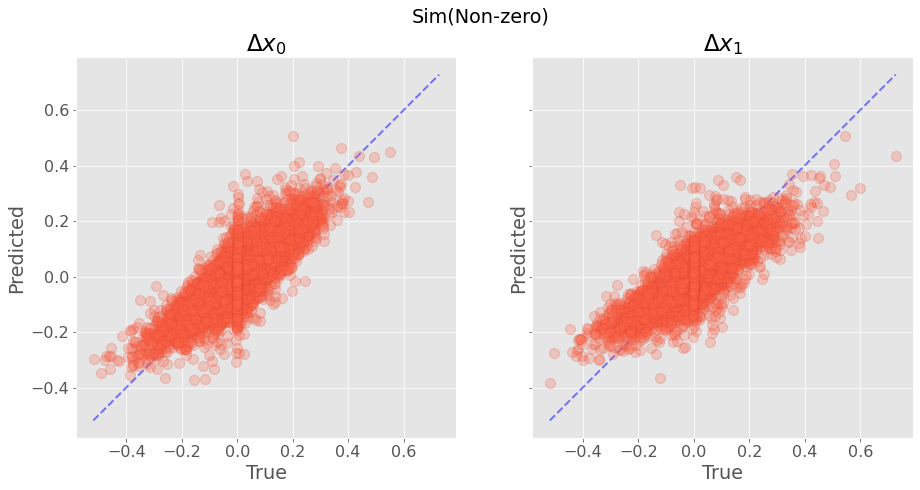

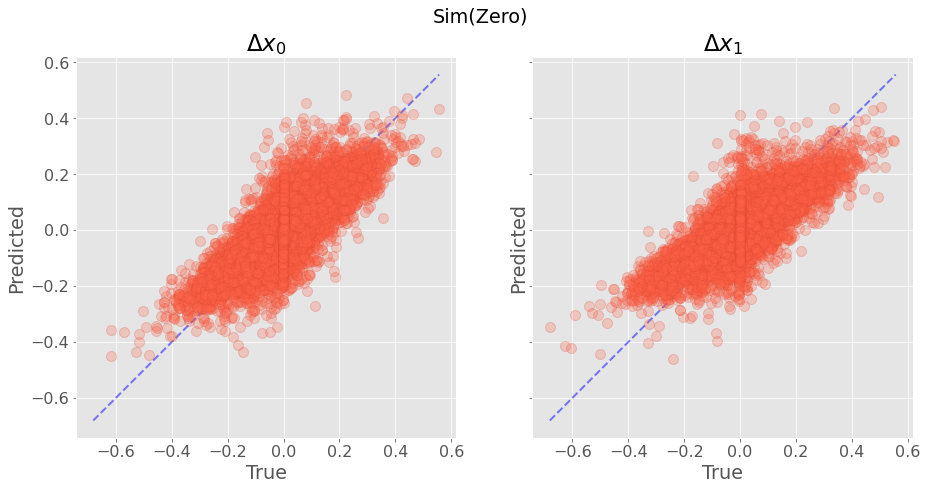

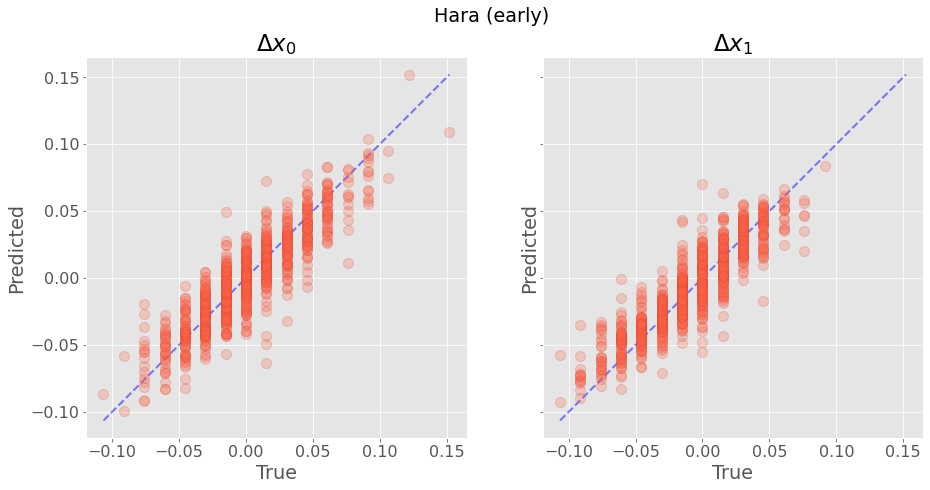

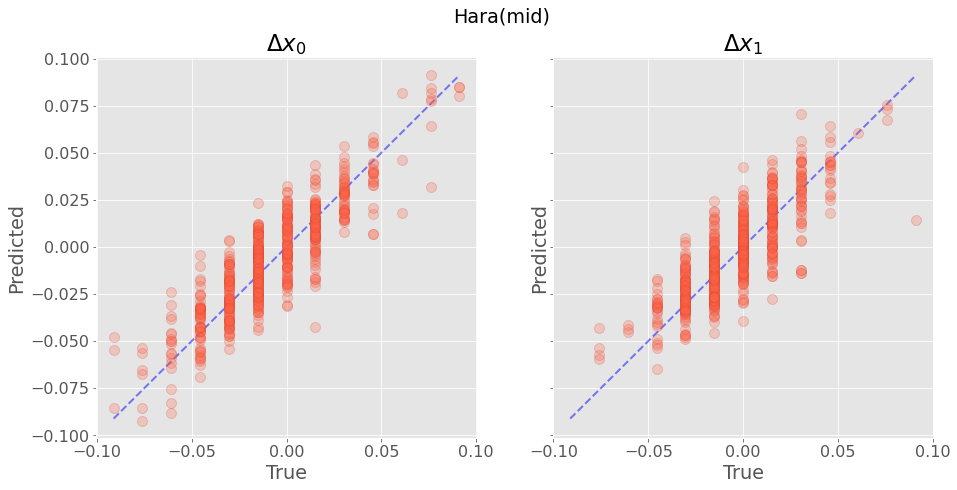

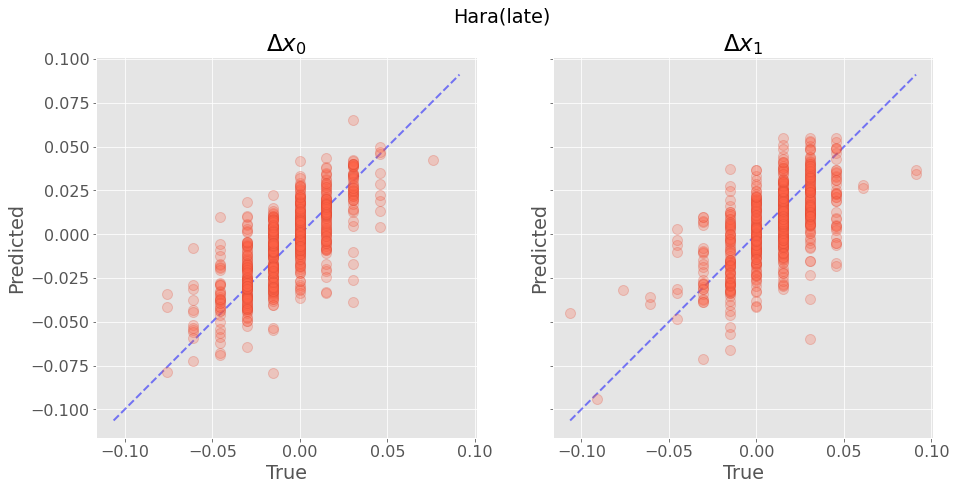

In [125]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [42]:
write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

Model weights saved in 
./simgnn_data/saved_models/05062021_193518_Single_MP_step_dp0.4bs2w5_net.pkl


#### Single MP Step Tension Model

In [181]:
from simgnn.nn import SingleMP_Tension

In [204]:
net

SingleMP_Tension(
  (message): DiffMessage(
    (mlp): mlp(
      (layers): Sequential(
        (0): Linear(in_features=12, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=16, bias=True)
      )
    )
  )
  (relu): ReLU()
  (aggr_update): AggregateUpdate(
    (mlp): mlp(
      (layers): Sequential(
        (0): Linear(in_features=26, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
        (3): ReLU()
        (4): Linear(in_features=16, out_features=8, bias=True)
        (5): ReLU()
        (6): Linear(in_features=8, out_features=2, bias=True)
      )
    )
  )
  (tension_mlp): mlp(
    (layers): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features

In [216]:
torch.manual_seed(0)

dropout_p = 0
num_epochs = 30
lr = 0.001
bs = 1
# loss_func = torch.nn.MSELoss(reduction='mean')
loss_func = torch.nn.L1Loss(reduction='mean')

net = SingleMP_Tension(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                       message_out_features=32, message_hidden_dims=[64,32,32],
                       tension_hidden_dims=[32,16,8,4],
                       aggr='mean', update_hidden_dims=[32,32,16,8], dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs,follow_batch=['cell_pressures','edge_index']),
           'val':    DataLoader(datasets_dict['hara'], batch_size=bs),
           'sim':   DataLoader(datasets_dict['sim'], batch_size=bs,follow_batch=['cell_pressures','edge_index']),}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 'val':[False, False], 'sim':[True,False] }

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [ ]:
print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

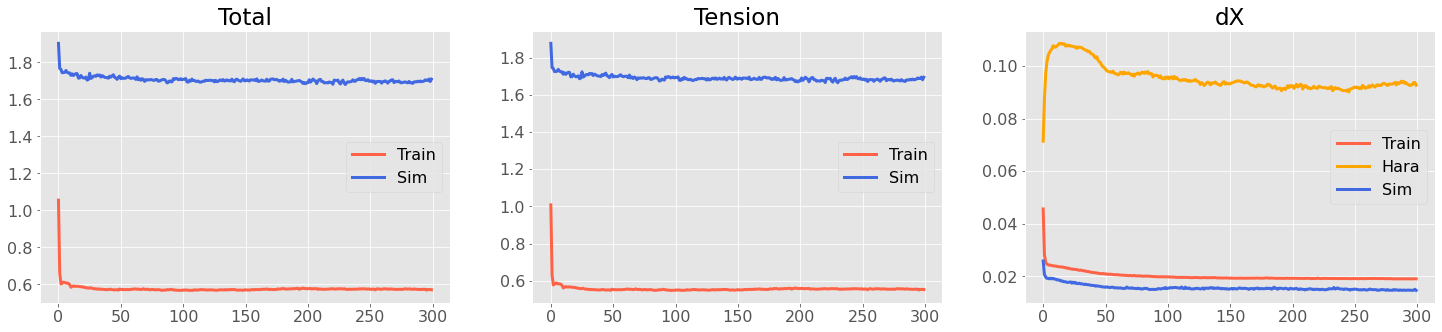

In [218]:
plt.figure(figsize=[25,5])
plt.subplot(1,3,1)
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_tot'],'tomato',lw=3,label='Train')
# plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=3,label='Hara')
plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
plt.legend(); plt.title('Total');


plt.subplot(1,3,2)
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_T'],'tomato',lw=3,label='Train')
# plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=3,label='Hara')
plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_T'],'royalblue',lw=3,label='Sim')
plt.legend(); plt.title('Tension');

plt.subplot(1,3,3)
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_y'],'tomato',lw=3,label='Train')
plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=3,label='Hara')
plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_y'],'royalblue',lw=3,label='Sim')
plt.legend(); plt.title('dX');

# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

- train_loss_tot =1.5567845357754333;
- train_loss_y =0.0009199676276689775;
- train_loss_T =1.5449148984980225;
- train_loss_P =None;
- val_loss_tot =0.014555223535638914;
- val_loss_y =0.014555223535638914;
- val_loss_T =None;
- val_loss_P =None;
- sim_loss_tot =3.5050782216017087;
- sim_loss_y =0.000599028583952486;
- sim_loss_T =3.5037273187216296;
- sim_loss_P =None;



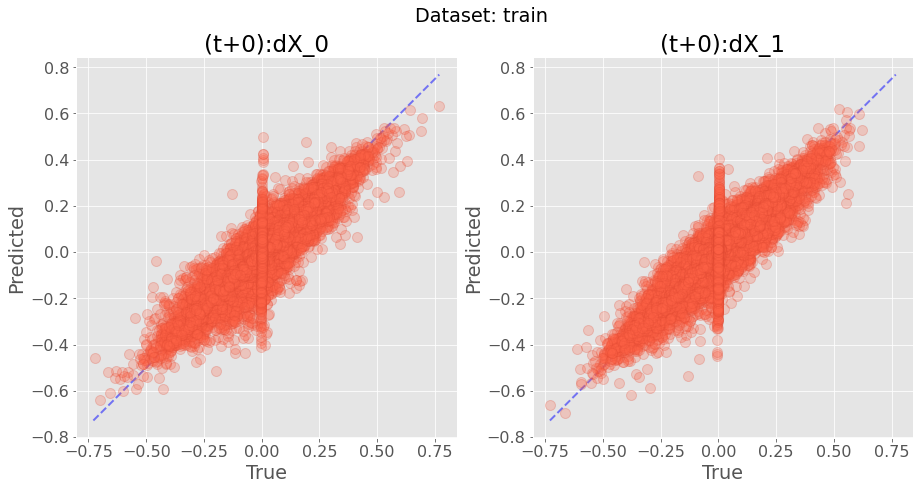

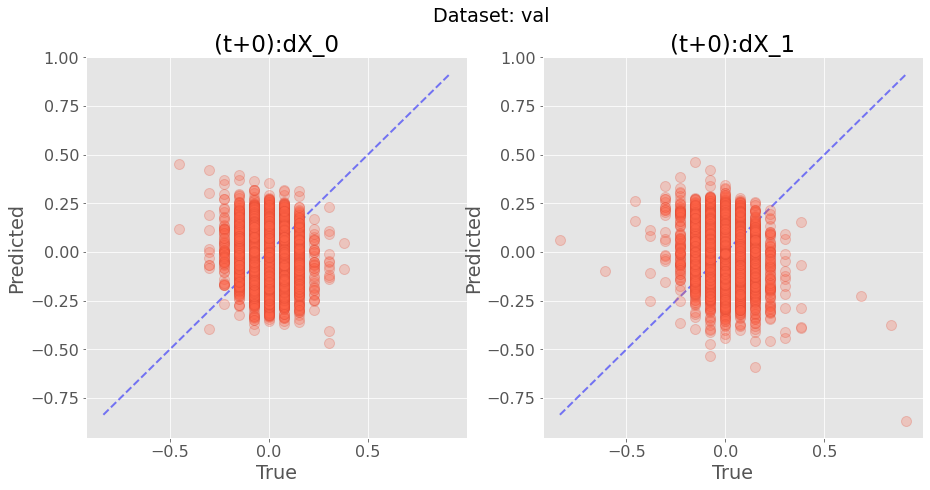

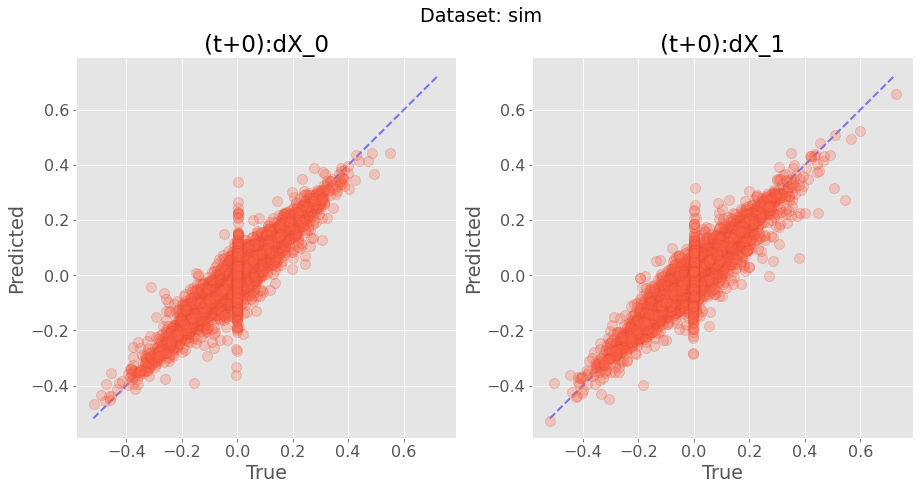

In [219]:
# loss_func = 
# loss_func = torch.nn.L1Loss(reduction='mean')
# bs = 32 
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))
var_type = 0
var_name = ['(t+0):dX', '(t+0):T', '(t+0):P' ]

for data_name in pred_out[0]:
    minY, maxY  = torch.cat(tgt_out[var_type][data_name],dim=0).min(), torch.cat(tgt_out[var_type][data_name],dim=0).max()
    
    plt.figure(figsize=[15,7])
    axs=[plt.subplot(1,2,1)]
    axs.append(plt.subplot(1,2,2,sharex=axs[0],sharey=axs[0]))
    
    for dim_k in range(2):
        axs[dim_k].plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
        axs[dim_k].plot(torch.cat(tgt_out[0][data_name],dim=0)[:,dim_k],
                        torch.cat(pred_out[0][data_name],dim=0)[:,dim_k],
                        'o',ms=10,mfc='tomato',alpha=.25)
        axs[dim_k].set_xlabel('True');
        axs[dim_k].set_ylabel('Predicted')
        axs[dim_k].set_title(f'{var_name[var_type]}_{dim_k}');
    plt.suptitle('Dataset: '+data_name)
    plt.show()